# Preprocessing and Prepare data input

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import rioxarray as rxr
from preprocess import utils_climate


**Dữ liệu tĩnh**

In [2]:
import numpy as np
from scipy.ndimage import generic_filter
import xarray as xr

def local_mean_fill(da: xr.DataArray, size=3):
    arr = da.values
    nan_mask = np.isnan(arr)

    def nanmean_filter(x):
        x = x[~np.isnan(x)]
        return np.mean(x) if x.size > 0 else np.nan

    local_means = generic_filter(arr, nanmean_filter, size=size, mode='mirror')
    
    filled_arr = arr.copy()
    filled_arr[nan_mask] = local_means[nan_mask]
    
    # Gán lại vào DataArray, giữ nguyên tọa độ
    return xr.DataArray(filled_arr, coords=da.coords, dims=da.dims, attrs=da.attrs)

In [3]:
# Thư mục dữ liệu
DATA_ROOT = "/mnt/storage/code/pywapor-clms/dataset"

# Đọc DEM tĩnh
dem_files = {
    "z": f"{DATA_ROOT}/dem/elevation_2000-01-01.tif",
    "slope": f"{DATA_ROOT}/dem/slope_2000-01-01.tif",
    "aspect": f"{DATA_ROOT}/dem/aspect_2000-01-01.tif",
    "t_amp": f"{DATA_ROOT}/t_amp/temp_amplitude_annual_2023-01-01.tif",  # nếu có
}

static_vars = {}
template = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/dataset/sm/2023-01-01.tif", masked=True).squeeze()

for var, path in dem_files.items():
    da = rxr.open_rasterio(path, masked=True).squeeze()

    if var == 'slope':
        da = utils_climate.degree_to_radian(da)

    da = utils_climate.resample_to_100m_match_template(da, template)

    # Fill NaN bằng local mean
    da = local_mean_fill(da)

    static_vars[var] = da


In [4]:
static_vars['aspect'].values

array([[160.      , 227.      , 208.16667 , ..., 188.5     ,  65.      ,
         90.      ],
       [ 20.      , 135.85715 , 227.      , ..., 227.      , 207.33333 ,
        227.      ],
       [180.      ,  47.      ,  90.      , ..., 192.      , 295.      ,
        340.      ],
       ...,
       [ 90.      , 270.      ,  15.      , ..., 227.      , 133.      ,
        180.      ],
       [133.      ,  20.      , 104.4     , ..., 115.      , 227.      ,
        270.      ],
       [ 57.666668,  76.5     ,  86.      , ..., 144.      , 204.      ,
        241.33333 ]], dtype=float32)

**Dữ liệu động (46 ngày NDVI, albedo, SM, thời tiết)**

In [6]:

from datetime import datetime
def get_list_date(folder_ndvi):
    """get list date of NDVI in series 

    Args:
        folder_ndvi (type: str): path to folder contain list NDVI image. 

    Returns:
        dict: list of all date follow to NDVI date.
    """
    list_name = os.listdir(folder_ndvi)
    list_dates = []
    for name in list_name:
        date_str = name.split('_')[-1].split('.')[0]
        list_dates.append(date_str)
    # Parse strings to datetime objects for accurate sorting
    list_dates_sorted = sorted(list_dates, key=lambda d: datetime.strptime(d, '%Y-%m-%d'))
    return list_dates_sorted

In [7]:
folder_ndvi = '/mnt/storage/code/pywapor-clms/dataset/ndvi/'
list_dates = get_list_date(folder_ndvi)

In [33]:
data_vars = {
    "t_air_24": [],
    "t_air_min_24": [],
    "t_air_max_24": [],
    "t_dew_24": [],
    "p_air_0_24": [],
    "u2m_24": [],
    "v2m_24": [],
    "p_24": [],
    "ra_flat_24": [],
    "albedo": [],
    "ndvi": [],
    "se_root": []
}

# Mapping từ tên biến cho vào file gốc
var_map = {
    "t_air_24": "temperature_2m",
    "t_air_min_24": "temperature_2m_min",
    "t_air_max_24": "temperature_2m_max",
    "t_dew_24": "dewpoint_temperature_2m",
    "p_air_0_24": "surface_pressure",
    "u2m_24": "u_component_of_wind_10m",
    "v2m_24": "v_component_of_wind_10m",
    "p_24": "total_precipitation_sum",
    "ra_flat_24": "surface_net_solar_radiation_sum"
}

def load_var(name, date, prefix="era5"):
    f = glob.glob(f"{DATA_ROOT}/{prefix}/{date}/{name}_{date}.tif")
    if not f:
        print(f"⚠️ Missing: {prefix}/{date}/{name}_{date}.tif")
        return None

    da = rxr.open_rasterio(f[0], masked=True).squeeze()
    da = utils_climate.resample_to_100m_match_template(da, template)

    if name in ['temperature_2m', 'temperature_2m_min', 'temperature_2m_max', 'dewpoint_temperature_2m']:
        return utils_climate.kevin_to_celcius(da)
    elif name == 'surface_net_solar_radiation_sum':
        return utils_climate.jun_to_mjun(da)
    elif name == 'surface_pressure':
        return utils_climate.pa_to_kpa(da)
    else:
        return da

valid_dates = []

for date in list_dates:
    day_path = os.path.join(DATA_ROOT, "era5", date)
    if not os.path.exists(day_path):
        print(f"❌ Era5 path not found for {date}")
        continue

    skip_date = False
    for var_key, filename_prefix in var_map.items():
        da = load_var(filename_prefix, date)
        if da is not None:
            if not isinstance(da, xr.DataArray):
                da = xr.DataArray(da)
            data_vars[var_key].append(local_mean_fill(da))
        else:
            skip_date = True
            break

    albedo_file = f"{DATA_ROOT}/albedo_s2/albedo_{date}.tif"
    if os.path.exists(albedo_file):
        albedo_da = rxr.open_rasterio(albedo_file, masked=True).squeeze()
        albedo_da = utils_climate.resample_to_100m_match_template(albedo_da,template)
        data_vars["albedo"].append(local_mean_fill(albedo_da))
    else:
        print(f"⚠️ Albedo file not found for {date}")
        skip_date = True


    ndvi_file = f"{DATA_ROOT}/ndvi/ndvi8days_infer_{date}.tif"
    if os.path.exists(ndvi_file):
        ndvi_da = rxr.open_rasterio(ndvi_file, masked=True).squeeze()
        ndvi_da = utils_climate.resample_to_100m_match_template(ndvi_da,template)
        data_vars["ndvi"].append(local_mean_fill(ndvi_da))
    else:
        print(f"⚠️ NDVI file not found for {date}")
        skip_date = True

    
    sm_file = f"{DATA_ROOT}/sm/{date}.tif"
    if os.path.exists(sm_file):
        sm_da = rxr.open_rasterio(sm_file, masked=True).squeeze()
        sm_da = sm_da.fillna(1)
        data_vars["se_root"].append(sm_da)

        # test sm ful 1
        # sm_da = rxr.open_rasterio(sm_file, masked=True).squeeze()
        # sm_da.data[:] = 1 
        # data_vars["se_root"].append(sm_da)
    else:
        print(f"⚠️ NDVI file not found for {date}")
        skip_date = True

    if not skip_date:
        valid_dates.append(date)



In [9]:
data_vars['ndvi'][0].values.shape

(43, 44)

In [10]:
data_vars['se_root'][45].values

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [11]:
import geopandas as gpd

# Đọc file GeoJSON
gdf = gpd.read_file("/mnt/storage/code/pywapor-clms/region.geojson")

# Lấy điểm trung tâm (centroid)
centroid = gdf.geometry.centroid.iloc[0]

# Tọa độ trung tâm
lon, lat = centroid.x, centroid.y

print(f"🧭 Tọa độ trung tâm: (lon: {lon}, lat: {lat})")


🧭 Tọa độ trung tâm: (lon: 106.42152524754306, lat: 20.476063838927757)


/tmp/ipykernel_19922/2176267415.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.geometry.centroid.iloc[0]


In [34]:
def prepare_data_input(static_vars, data_vars, index, date):
    coords = {
        "x": static_vars["slope"].coords["x"],
        "y": static_vars["slope"].coords["y"],
        "time_bins": [np.datetime64(date)]
    }

    ds = xr.Dataset(
        data_vars=dict(
            doy=(("time_bins",), [utils_climate.date_to_doy(date)]),  # mở rộng theo time_bins
            ndvi=(("y", "x"), data_vars["ndvi"][index].values),
            ra_flat_24=(("y", "x"), data_vars["ra_flat_24"][index].values),
            slope=(("y", "x"), static_vars["slope"].values),
            aspect=(("y", "x"), static_vars["aspect"].values),
            p_air_0_24=(("y", "x"), data_vars["p_air_0_24"][index].values),
            z=(("y", "x"), static_vars["z"].values),
            t_dew_24=(("y", "x"), data_vars["t_dew_24"][index].values),
            t_air_24=(("y", "x"), data_vars["t_air_24"][index].values),
            t_air_min_24=(("y", "x"), data_vars["t_air_min_24"][index].values),
            t_air_max_24=(("y", "x"), data_vars["t_air_max_24"][index].values),
            se_root=(("y", "x"), data_vars["se_root"][index].values),
            u2m_24=(("y", "x"), data_vars["u2m_24"][index].values),
            v2m_24=(("y", "x"), data_vars["v2m_24"][index].values),
            p_24=(("y", "x"), data_vars["p_24"][index].values),
            t_amp=(("y", "x"), static_vars["t_amp"].values),
            r0 = (("y", "x"), data_vars["albedo"][index].values)
        ),
        coords=coords,
    )
    
    ds.encoding["source"] = f"/mnt/storage/code/pywapor-clms/res/{date}/res_{date}"
    
    return ds


In [35]:
ds_input = prepare_data_input(static_vars, data_vars, 15, '2023-05-01')

# **Calculating**

In [14]:
from pywapor.et_look import main

/home/nhatvm/miniconda3/envs/my_pywapor_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
ds_input.dims

FrozenMappingWarningOnValuesAccess({'time_bins': 1, 'y': 43, 'x': 44})

In [37]:
main(ds_input, et_look_version='v3', export_vars="default", chunks={})

        > ET_LOOK
            --> Running `et_look` (v3).
            --> Setting `rs_min` to `100`.
            --> Setting `land_mask` to `1`.
            --> Setting `z_obst_max` to `3`.
            --> Calculating `declination`.
            --> Calculating `inverse_earth_sun_distance`.
            --> Calculating `vegetation_cover`.
            --> Calculating `leaf_area_index`.
            --> Calculating `effective_leaf_area_index`.
            --> Calculating `soil_fraction`.
            --> Calculating `latitude_rad`.
            --> Calculating `sunset_hour_angle`.
            --> Calculating `daily_solar_radiation_toa_flat`.
            --> Calculating `transmissivity`.
            --> Calculating `seasonal_correction`.
            --> Calculating `daily_solar_radiation_toa`.
            --> Calculating `cosine_solar_zenith_angle`.
            --> Calculating `inst_solar_radiation_toa`.
            --> Calculating `transmissivity`.
            --> Calculating `diffusion_index

AttributeError: 'NoneType' object has no attribute 'render'

<xarray.Dataset> Size: 76kB
Dimensions:      (y: 43, x: 44, time_bins: 1)
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) float64 352B 106.4 106.4 106.4 106.4 ... 106.4 106.4 106.4
  * y            (y) float64 344B 20.49 20.49 20.49 20.49 ... 20.46 20.46 20.46
  * time_bins    (time_bins) datetime64[ns] 8B 2023-05-01
Data variables:
    int_mm       (y, x) float64 15kB dask.array<chunksize=(43, 44), meta=np.ndarray>
    t_24_mm      (time_bins, y, x) float64 15kB dask.array<chunksize=(1, 43, 44), meta=np.ndarray>
    e_24_mm      (time_bins, y, x) float64 15kB dask.array<chunksize=(1, 43, 44), meta=np.ndarray>
    aeti_24_mm   (time_bins, y, x) float64 15kB dask.array<chunksize=(1, 43, 44), meta=np.ndarray>
    se_root      (y, x) float64 15kB dask.array<chunksize=(43, 44), meta=np.ndarray>
Attributes:
    pyWaPOR_bb:      unknown
    pyWaPOR_period:  unknown

# Check result

In [38]:
import xarray as xr

# Mở dataset từ file NetCDF

ds1 = xr.open_dataset("/mnt/storage/code/pywapor-clms/res/2023-05-01/res_2023-05-01")

# Xem thông tin tổng quan dataset
print(ds1)

# Giả sử biến ET có tên là 'et' hoặc tương tự, kiểm tra danh sách biến
print(ds1.data_vars)

# Lấy biến ET ra (ví dụ 'et_reference_mm' hoặc 'et_look' tùy biến)
et_var_name = 'aeti_24_mm'  # thay bằng tên đúng nếu khác

if et_var_name in ds_input:
    et_data = ds_input[et_var_name]
    print(et_data)
    # Xem vài giá trị đầu tiên
    print(et_data.values[:10])
else:
    print(f"Biến {et_var_name} không có trong dataset")

<xarray.Dataset> Size: 76kB
Dimensions:      (y: 43, x: 44, time_bins: 1)
Coordinates:
  * x            (x) float64 352B 106.4 106.4 106.4 106.4 ... 106.4 106.4 106.4
  * y            (y) float64 344B 20.49 20.49 20.49 20.49 ... 20.46 20.46 20.46
  * time_bins    (time_bins) datetime64[ns] 8B 2023-05-01
Data variables:
    int_mm       (y, x) float64 15kB ...
    t_24_mm      (time_bins, y, x) float64 15kB ...
    e_24_mm      (time_bins, y, x) float64 15kB ...
    aeti_24_mm   (time_bins, y, x) float64 15kB ...
    se_root      (y, x) float64 15kB ...
    spatial_ref  int64 8B ...
Attributes:
    pyWaPOR_bb:      unknown
    pyWaPOR_period:  unknown
Data variables:
    int_mm       (y, x) float64 15kB ...
    t_24_mm      (time_bins, y, x) float64 15kB ...
    e_24_mm      (time_bins, y, x) float64 15kB ...
    aeti_24_mm   (time_bins, y, x) float64 15kB ...
    se_root      (y, x) float64 15kB ...
    spatial_ref  int64 8B ...
Biến aeti_24_mm không có trong dataset


In [39]:
for var in ds1.data_vars:
    print(f"== {var} ==")
    print(ds1[var].values)

== int_mm ==
[[2.0e-07 4.4e-07 4.2e-07 ... 6.1e-07 2.9e-07 8.6e-07]
 [6.8e-07 7.0e-08 4.1e-07 ... 0.0e+00 4.5e-07 5.5e-07]
 [8.6e-07 1.0e-08 4.5e-07 ... 0.0e+00 2.9e-07 5.1e-07]
 ...
 [1.9e-07 1.5e-07 3.3e-07 ... 8.6e-07 8.6e-07 5.3e-07]
 [7.2e-07 5.2e-07 8.6e-07 ... 8.6e-07 7.0e-07 8.5e-07]
 [5.8e-07 6.8e-07 6.0e-07 ... 8.6e-07 8.1e-07 7.4e-07]]
== t_24_mm ==
[[[4.12558420e-01 9.46541070e-01 8.30349860e-01 ... 1.46670257e+00
   5.61187910e-01 1.27046631e+00]
  [1.19968283e+00 1.70717950e-01 7.02362960e-01 ... 6.57800000e-04
   6.51152420e-01 7.70617110e-01]
  [1.37074986e+00 1.51390300e-02 8.08838290e-01 ... 6.57800000e-04
   4.40038840e-01 7.33033840e-01]
  ...
  [3.94911570e-01 3.07501340e-01 6.29447430e-01 ... 1.27601102e+00
   1.30990223e+00 8.77813620e-01]
  [1.14118733e+00 8.90702660e-01 1.35675013e+00 ... 1.25051927e+00
   1.11321312e+00 1.24355208e+00]
  [1.49682669e+00 1.63544403e+00 1.52875187e+00 ... 1.78753346e+00
   1.75201484e+00 1.68584647e+00]]]
== e_24_mm ==
[[[0.1272

In [40]:
et_values = ds1["aeti_24_mm"].compute().values
print("AETI (e_24_mm) values:", et_values)

# Nếu muốn xem dạng array 3D (time, y, x)
print("Shape:", et_values.shape)

# Nếu chỉ có 1 điểm như bạn, in giá trị đơn giản:
print(f"AETI 24h (mm): {et_values[0,0,0]}")


AETI (e_24_mm) values: [[[0.53982928 1.09097026 0.95594996 ... 1.87082569 0.67669035 1.36320448]
  [1.30971979 0.30865603 0.80707031 ... 0.45727936 0.73169113 0.84903179]
  [1.46593232 0.16304338 0.92088186 ... 0.45927521 0.52569321 0.81532699]
  ...
  [0.52533121 0.42808513 0.74999702 ... 1.35739271 1.40057048 0.97629327]
  [1.23167584 0.99438441 1.45092322 ... 1.33052968 1.20476593 1.32597291]
  [1.92321098 2.04615426 1.95122865 ... 2.17939861 2.14552844 2.08594384]]]
Shape: (1, 43, 44)
AETI 24h (mm): 0.53982928


**xuat ra anh tif**

In [41]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

# Lấy giá trị
aeti = ds1["aeti_24_mm"].isel(time_bins=0).values  # (y, x)
aeti = np.squeeze(aeti)

# Lấy thông tin tọa độ
x = ds1.coords["x"].values
y = ds1.coords["y"].values

# Tính affine transform
res_x = abs(x[1] - x[0])
res_y = abs(y[1] - y[0])
transform = from_origin(x[0] - res_x / 2, y[0] + res_y / 2, res_x, res_y)

# Lưu GeoTIFF
with rasterio.open(
    "aeti_24_v3_mm_sm_1_5_2023.tif",
    "w",
    driver="GTiff",
    height=aeti.shape[0],
    width=aeti.shape[1],
    count=1,
    dtype=aeti.dtype,
    crs="EPSG:4326",  # Hoặc CRS đúng từ ds1 nếu có
    transform=transform,
) as dst:
    dst.write(aeti, 1)


# 3 band to 1 band SM

In [28]:
import glob
import rasterio
input_folder = "/mnt/storage/code/pywapor-clms/dataset/sm/"
output_folder = "/mnt/storage/code/pywapor-clms/dataset/sm/"
os.makedirs(output_folder, exist_ok=True)

for tif_path in glob.glob(os.path.join(input_folder, "*.tif")):
    with rasterio.open(tif_path) as src:
        band1 = src.read(1)
        profile = src.profile.copy()
    
    profile.update({"count": 1, "dtype": band1.dtype, "compress": "lzw"})
    out_path = os.path.join(output_folder, os.path.basename(tif_path))
    
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(band1, 1)


# TEMP: XUAT FILE GEOJSON

In [56]:
import os
import json
import ee
import rasterio
from pyproj import Transformer

# Khởi tạo Earth Engine
ee.Initialize(project='ee-minhnhat8dc')

# Đường dẫn NDVI
folder_ndvi = '/mnt/storage/code/pywapor-clms/dataset/ndvi/'
list_dates = get_list_date(folder_ndvi)
ndvi_file = os.path.join(folder_ndvi, f"ndvi8days_infer_{list_dates[0]}.tif")

# Đọc bounds từ ảnh raster
with rasterio.open(ndvi_file) as src:
    bounds = src.bounds
    crs = src.crs

# Chuyển về EPSG:4326 (lat/lon)
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
ll = transformer.transform(bounds.left, bounds.bottom)
lr = transformer.transform(bounds.right, bounds.bottom)
ur = transformer.transform(bounds.right, bounds.top)
ul = transformer.transform(bounds.left, bounds.top)
coords = [ul, ur, lr, ll, ul]

# Tạo polygon EE
region = ee.Geometry.Polygon([coords])

# Lấy GeoJSON dictionary
region_geojson = region.getInfo()

# Ghi ra file GeoJSON
output_path = "/mnt/storage/code/pywapor-clms/region.geojson"
with open(output_path, "w") as f:
    json.dump(region_geojson, f, indent=2)

print(f"✅ Đã lưu GeoJSON tại: {output_path}")


✅ Đã lưu GeoJSON tại: /mnt/storage/code/pywapor-clms/region.geojson


# Chuyen crs 300 ve 100 

In [19]:
import os
import glob
import xarray as xr
import rioxarray
from tqdm import tqdm

# ✅ Đường dẫn thư mục gốc chứa các ảnh
DATA_ROOT = "/mnt/storage/code/pywapor-clms/data_valid/AnBinh_KienXuong_ThaiBinh"

# ✅ Template image: ảnh gốc 100m dùng làm mẫu
TEMPLATE_PATH = f"/mnt/storage/code/pywapor-clms/dataset/sm/2023-01-01.tif"
template = rioxarray.open_rasterio(TEMPLATE_PATH, masked=True).squeeze()

# ✅ Thư mục output
OUTPUT_ROOT = f"{DATA_ROOT}_resampled_100m"

# ✅ Duyệt toàn bộ ảnh TIF trong thư mục gốc
tif_paths = glob.glob(f"{DATA_ROOT}/**/*.tif", recursive=True)

for tif_path in tqdm(tif_paths, desc="Resampling"):
    try:
        # Mở ảnh
        da = rioxarray.open_rasterio(tif_path, masked=True)
        da_resampled = utils_climate.resample_to_100m_match_template(da, template)

        # Tạo đường dẫn output tương ứng
        rel_path = os.path.relpath(tif_path, DATA_ROOT)
        output_path = os.path.join(OUTPUT_ROOT, rel_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Ghi file đã resample
        da_resampled.rio.to_raster(output_path)
    except Exception as e:
        print(f"❌ Error processing {tif_path}: {e}")


Resampling: 100%|██████████| 36/36 [00:00<00:00, 110.36it/s]


# Test MSE, RMSE of 2 image tif

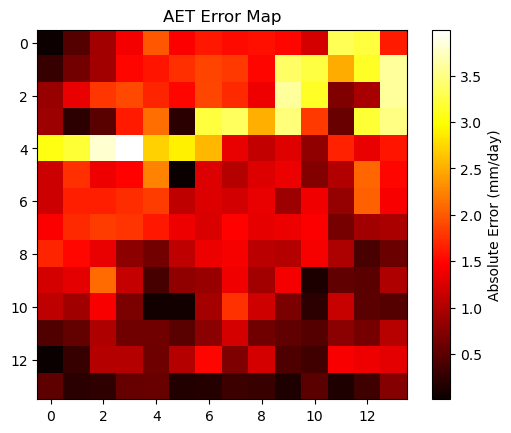

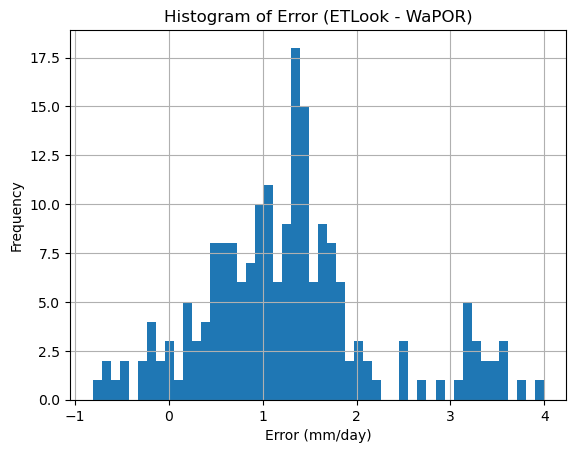

MSE: 2.4880
RMSE: 1.5773


In [45]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

def compute_mse_rmse(path1: str, path2: str):
    # Mở 2 ảnh và squeeze để loại chiều dư (nếu có band)
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * 0.1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze()

    # Đảm bảo cùng shape
    if img1.shape != img2.shape:
        raise ValueError(f"Different shapes: {img1.shape} vs {img2.shape}")
    # Convert về numpy array
    arr1 = img1.values
    arr2 = img2.values
    # Mặt nạ hợp lệ: cả hai ảnh đều không bị mask
    mask = (~np.isnan(arr1)) & (~np.isnan(arr2))

    error_map = np.full_like(arr1, np.nan)
    error_map[mask] = np.abs(arr1[mask] - arr2[mask])

    plt.imshow(error_map, cmap="hot")
    plt.colorbar(label="Absolute Error (mm/day)")
    plt.title("AET Error Map")
    plt.show()
    # Tính MSE và RMSE
    mse = np.mean((arr1[mask] - arr2[mask]) ** 2)
    rmse = np.sqrt(mse)

    plt.hist(arr1[mask] - arr2[mask], bins=50)
    plt.title("Histogram of Error (ETLook - WaPOR)")
    plt.xlabel("Error (mm/day)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    return mse, rmse

# 🔧 Ví dụ sử dụng:
path_img1 = "/mnt/storage/code/pywapor-clms/data_valid/AnBinh_KienXuong_ThaiBinh/cropped_WAPOR-3.L1-AETI-D.2023-05-D1_b7f2e3fe.tif"
path_img2 = "/mnt/storage/code/pywapor-clms/aeti_resampled_to_300m_v3_sm_1_5_2023.tif"

mse, rmse = compute_mse_rmse(path_img1, path_img2)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


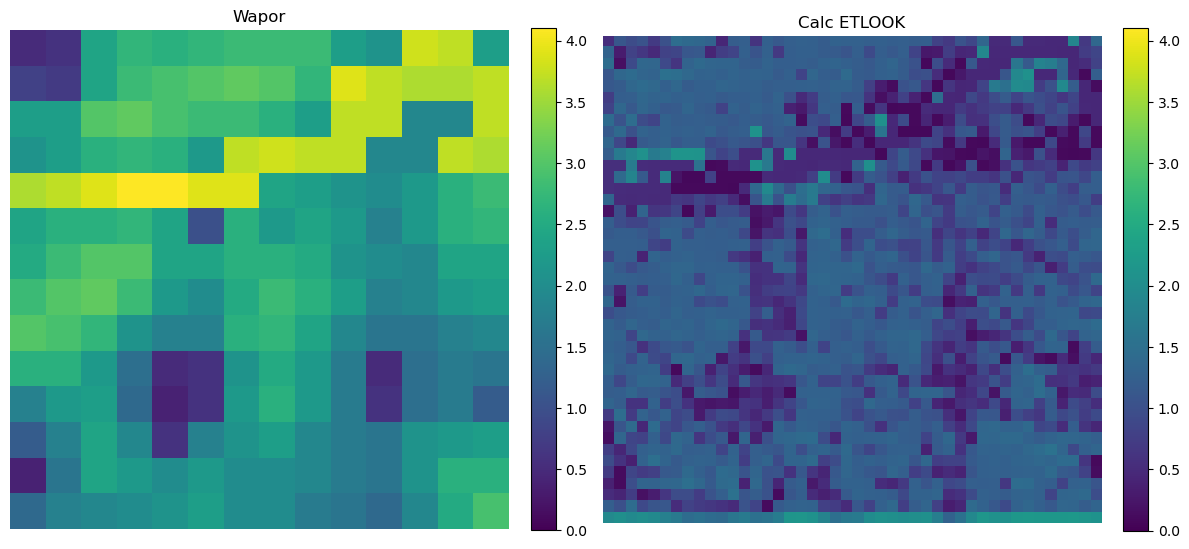

In [47]:
import rioxarray
import matplotlib.pyplot as plt

def show_two_images(path1: str, path2: str, titles=("Image 1", "Image 2"), cmap="viridis", vmin=0, vmax=4.1):
    # Đọc ảnh và squeeze để bỏ chiều band nếu có
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * 0.1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze()

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    im1 = axs[0].imshow(img1, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_title(titles[0])
    axs[0].axis("off")
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

    im2 = axs[1].imshow(img2, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title(titles[1])
    axs[1].axis("off")
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# 🔧 Ví dụ sử dụng
path_img1 = "/mnt/storage/code/pywapor-clms/data_valid/AnBinh_KienXuong_ThaiBinh/cropped_WAPOR-3.L1-AETI-D.2023-05-D1_b7f2e3fe.tif"
path_img2 = "/mnt/storage/code/pywapor-clms/aeti_24_v3_mm_sm_1_5_2023.tif"

show_two_images(path_img1, path_img2, titles=["Wapor", "Calc ETLOOK"])


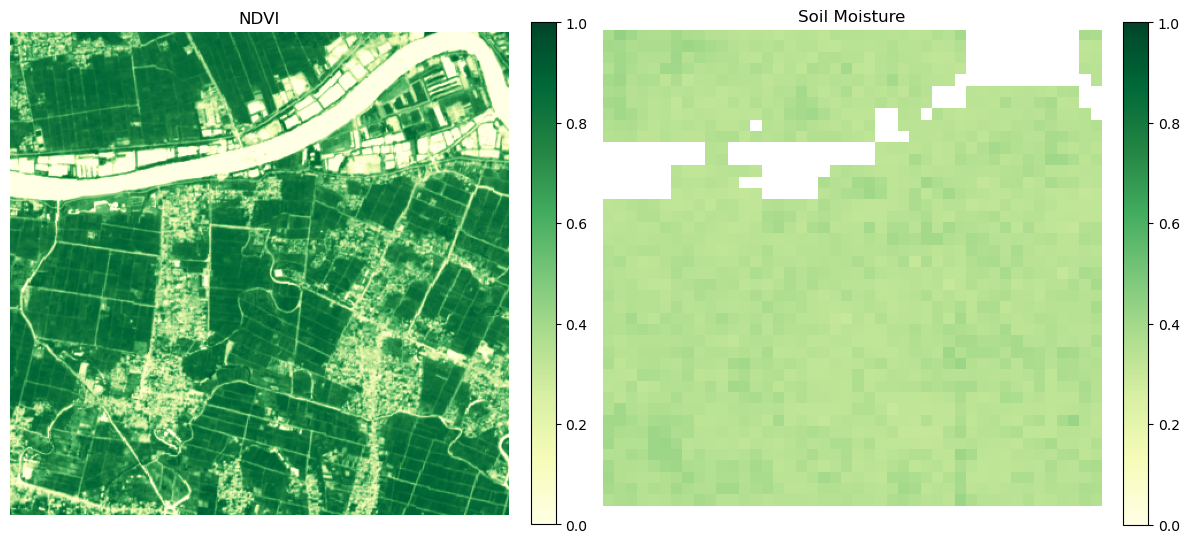

In [25]:
import rioxarray
import matplotlib.pyplot as plt

def show_two_images(path1: str, path2: str, titles=("Image 1", "Image 2"), cmap="viridis", vmin=None, vmax=None, scale1=1.0, scale2=1.0):
    # Đọc ảnh và scale
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * scale1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze() * scale2

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    im1 = axs[0].imshow(img1, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_title(titles[0])
    axs[0].axis("off")
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

    im2 = axs[1].imshow(img2, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title(titles[1])
    axs[1].axis("off")
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# 🧪 Ví dụ sử dụng: NDVI và SM
path_ndvi = "/mnt/storage/code/pywapor-clms/dataset/ndvi/ndvi8days_infer_2023-05-01.tif"
path_sm = "/mnt/storage/code/pywapor-clms/dataset/sm/2023-05-01.tif"

# NDVI thường trong khoảng -1 → 1
show_two_images(path_ndvi, path_sm, titles=["NDVI", "Soil Moisture"], cmap="YlGn", vmin=0, vmax=1)


In [26]:
import rioxarray
import numpy as np

# Đọc ảnh SM (giả sử bạn đang dùng định dạng GeoTIFF)
sm_path = "/mnt/storage/code/pywapor-clms/dataset/sm/2023-05-01.tif"
sm = rioxarray.open_rasterio(sm_path, masked=True).squeeze()

# Loại bỏ giá trị NaN
valid_sm = sm.values[~np.isnan(sm.values)]

# Tính min, max, mean
min_val = np.min(valid_sm)
max_val = np.max(valid_sm)
mean_val = np.mean(valid_sm)

print(f"SM range: {min_val:.4f} – {max_val:.4f}")
print(f"Mean SM: {mean_val:.4f}")


SM range: 0.3008 – 0.4352
Mean SM: 0.3473


📊 WaPOR stats:
  min: 0.4000
  max: 4.1000
  mean: 2.3270
  std: 0.7774

📊 ETLOOK stats:
  min: 0.0891
  max: 2.1660
  mean: 1.0605
  std: 0.4553


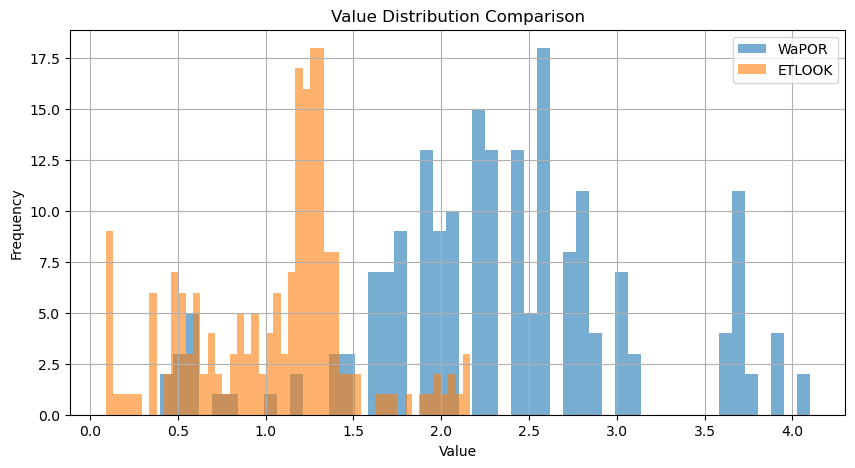

In [48]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

def compare_stats_and_distribution(path1, path2, scale1=0.1, scale2=1.0, title1="Image 1", title2="Image 2"):
    # Mở ảnh và scale
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * scale1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze() * scale2

    # Chuyển về numpy và loại giá trị NaN
    arr1 = img1.values
    arr2 = img2.values
    arr1_valid = arr1[~np.isnan(arr1)]
    arr2_valid = arr2[~np.isnan(arr2)]

    # So sánh thống kê
    def stats(arr):
        return {
            "min": np.min(arr),
            "max": np.max(arr),
            "mean": np.mean(arr),
            "std": np.std(arr)
        }

    stats1 = stats(arr1_valid)
    stats2 = stats(arr2_valid)

    print(f"📊 {title1} stats:")
    for k, v in stats1.items():
        print(f"  {k}: {v:.4f}")

    print(f"\n📊 {title2} stats:")
    for k, v in stats2.items():
        print(f"  {k}: {v:.4f}")

    # Vẽ histogram
    plt.figure(figsize=(10, 5))
    plt.hist(arr1_valid, bins=50, alpha=0.6, label=title1)
    plt.hist(arr2_valid, bins=50, alpha=0.6, label=title2)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Value Distribution Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

# 🧪 Gọi hàm
path_img1 = "/mnt/storage/code/pywapor-clms/data_valid/AnBinh_KienXuong_ThaiBinh/cropped_WAPOR-3.L1-AETI-D.2023-05-D1_b7f2e3fe.tif"
path_img2 = "/mnt/storage/code/pywapor-clms/aeti_resampled_to_300m_v3_sm_1_5_2023.tif"

compare_stats_and_distribution(path_img1, path_img2, scale1=0.1, scale2=1.0,
                               title1="WaPOR", title2="ETLOOK")


# chuyển 100m về 300m 

In [43]:
import rioxarray as rxr

# Mở ảnh gốc 100m
da_100m = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/aeti_24_v3_mm_sm_1_5_2023.tif", masked=True).squeeze()

# Mở ảnh mẫu 300m
template_300m = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/cropped_WAPOR-3.L1-AETI-D.2023-01-D1_ef14dcbb.tif", masked=True).squeeze()

# Đảm bảo khớp CRS
if not da_100m.rio.crs:
    da_100m = da_100m.rio.write_crs(template_300m.rio.crs)

# Resample về 300m
da_300m = da_100m.rio.reproject_match(template_300m)

# Lưu ảnh mới ra file .tif
da_300m.rio.to_raster("aeti_resampled_to_300m_v3_sm_1_5_2023.tif")
